In [ ]:
pip install vectorbt

In [ ]:
pip install -U kaleido

In [ ]:
pip install pandas_ta

###DMAC策略结合波动率止损
这个notebook实现了一个双均线交叉（DMAC）策略，并使用平均真实波动范围（ATR）进行风险管理，应用追踪止损机制保护利润。

选择DMAC策略的原因：
1. 高流动性：EUR/USD流动性强，交易成本低，DMA策略能稳定捕捉趋势，不易受到滑点影响。
2. 趋势性明显：该货币对常呈现中短期趋势，DMA策略适合捕捉这些趋势并跟随波动。
3. 降低频繁交易：DMA过滤短期噪音，减少交易频次，降低交易成本。
4. 应对波动性：ATR止损动态调整，适应市场波动，保护利润，控制风险。
5. EUR/USD特性：全球交易量最大，受经济因素影响波动规律，DMA策略可捕捉持续的趋势信号。

主要步骤：
1. 定义窗口最小和最大范围。
2. 使用网格搜索测试不同的快慢窗口组合
3. 选择总回报率最大的窗口组合
4. 应用基于ATR的波动率止损和追踪止损

##数据载入和参数初始化设定

交易对象：EUR/USD

交易区间：2024-08-30——2024-10-22

虽然时间不足两个月（日内频次数据最多免费到这个区间），但是测试了多个外汇交易对，回测结果良好，说明该策略具有一定的稳健性。

交易成本：
* 初始资金$10000
* 滑点：0.00025
* 交易手续费：0.00025
* 交易延迟：信号发出后的下一个时间点成交


In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import pytz
from datetime import datetime,timedelta
from dateutil.parser import parse
from ipywidgets import widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly.graph_objects as go
import itertools
import dateparser
import gc
import yfinance as yf

In [2]:
import pandas_ta as ta

In [3]:
#参数
seed=44
symbol='EURUSD=x'
metric='total_return'
vbt.settings.portfolio['init_cash']=10000
vbt.settings.portfolio['fees']=0.00025
vbt.settings.portfolio['slippage']=0.00025


In [4]:
#加载数据
data=yf.download(symbol,start='2024-08-30',end='2024-10-22',interval='30m')

[*********************100%***********************]  1 of 1 completed


In [5]:
data['ATR']=data.ta.atr()

In [6]:
print(data.shape)
data[:5]

(1752, 7)


,Open,High,Low,Close,Adj Close,Volume,ATR
Datetime,,,,,,,
2024-08-30 00:00:00,1.108279,1.108525,1.108156,1.108402,1.108402,0,NaN
2024-08-30 00:30:00,1.108279,1.108402,1.108156,1.108279,1.108279,0,NaN
2024-08-30 01:00:00,1.108279,1.108647,1.108279,1.108525,1.108525,0,NaN
2024-08-30 01:30:00,1.108402,1.108525,1.108279,1.108402,1.108402,0,NaN
2024-08-30 02:00:00,1.108402,1.108525,1.108156,1.108279,1.108279,0,NaN


In [7]:
data.dropna(inplace=True)

In [8]:
data.shape

(1738, 7)

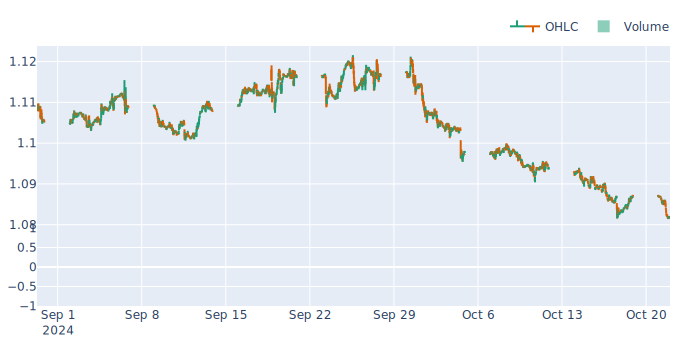

In [10]:
data.vbt.ohlcv.plot().show_svg()

###网格搜索定义快慢窗口
设置窗口范围：5—260

在窗口范围内遍历测试不同的快速和慢速窗口组合进行初步筛选，选择总回报率最大的一对窗口组合为最佳窗口组合。


In [11]:
#不同的窗口组合
#设置窗口大小
min_window=5
max_window=260
fast_ma,slow_ma=vbt.MA.run_combs(
    data['Close'],np.arange(min_window,max_window+1),
    r=2,short_names=['fast_ma','slow_ma']
)

In [12]:
dmac_entries = fast_ma.ma_crossed_above(slow_ma)
dmac_exits = fast_ma.ma_crossed_below(slow_ma)

# 交易延迟
dmac_entries = dmac_entries.shift(1)
dmac_exits = dmac_exits.shift(1)

dmac_short_entries = fast_ma.ma_crossed_below(slow_ma).shift(1)
dmac_short_exits = fast_ma.ma_crossed_above(slow_ma).shift(1)

# 确保没有因移动信号而导致的NaN值
dmac_entries.fillna(False, inplace=True)
dmac_exits.fillna(False, inplace=True)
dmac_short_entries.fillna(False, inplace=True)
dmac_short_exits.fillna(False, inplace=True)

<ipython-input-12-ed1166790187>:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-12-ed1166790187>:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-12-ed1166790187>:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-12-ed1166790187>:15: FutureWarning:

Downcasting object dtype arrays on .fillna

In [13]:
dmac_pf=vbt.Portfolio.from_signals(data['Close'],dmac_entries,dmac_exits,dmac_short_entries,dmac_short_exits)

In [14]:
dmac_perf=dmac_pf.deep_getattr(metric)

In [15]:
dmac_perf_matrix=dmac_perf.vbt.unstack_to_df(symmetric=True,
index_levels='fast_ma_window',column_levels='slow_ma_window')

下图将初步筛选中所有窗口组合的回报率作图，颜色越浅回报率越高

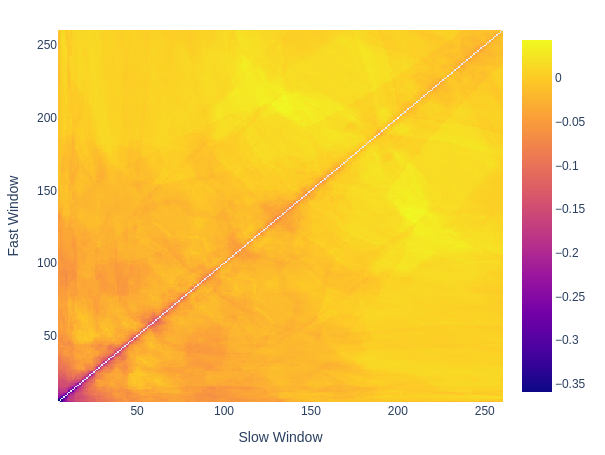

In [30]:
dmac_perf_matrix.vbt.heatmap(
    xaxis_title='Slow Window',
    yaxis_title='Fast Window'
).show_png()

In [22]:
print(f'目前总回报最大的组合是：{dmac_perf.idxmax()}')

目前总回报最大的组合是：(129, 210)


In [23]:
fast_win=dmac_perf.idxmax()[0]
slow_win=dmac_perf.idxmax()[1]

###定义基于ATR的止损和追踪止损函数
这里使用ATR指标动态设置止损和止盈，Ratio控制ATR的放大倍数

In [19]:
import numba as nb

In [20]:
@nb.njit
def sl(context,atr,Ratio=1):
  close=context.val_price_now
  signal=context.position_now

  sl=close
  trailing=True
  slatr=atr[context.i]*Ratio

  if signal==1:
    sl=close-slatr

  if signal==-1:
    sl=close+slatr

  return sl,trailing

@nb.njit
def tp(context,atr,Ratio=1):
  close=context.val_price_now
  signal=context.position_now

  tp=close
  trailing=False
  slatr=atr[context.i]*Ratio

  if signal==1:
    tp=close+slatr*Ratio

  if signal==-1:
    tp=close-slatr*Ratio

  return tp


atr=np.array(data['ATR'],dtype=np.float64)

In [21]:
fast_ma=vbt.MA.run(data['Close'],fast_win)
slow_ma=vbt.MA.run(data['Close'],slow_win)
dmac_entries = fast_ma.ma_crossed_above(slow_ma)
dmac_exits = fast_ma.ma_crossed_below(slow_ma)

# 模拟交易延迟
dmac_entries = dmac_entries.shift(1)
dmac_exits = dmac_exits.shift(1)
dmac_short_entries = fast_ma.ma_crossed_below(slow_ma).shift(1)
dmac_short_exits = fast_ma.ma_crossed_above(slow_ma).shift(1)

# 确保没有因移动信号而导致的NaN值
dmac_entries.fillna(False, inplace=True)
dmac_exits.fillna(False, inplace=True)
dmac_short_entries.fillna(False, inplace=True)
dmac_short_exits.fillna(False, inplace=True)

<ipython-input-21-1e63abc4ff79>:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-21-1e63abc4ff79>:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-21-1e63abc4ff79>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-21-1e63abc4ff79>:16: FutureWarning:

Downcasting object dtype arrays on .fillna

###回测结果

In [24]:

dmac_pf=vbt.Portfolio.from_signals(data['Close'],
                                     dmac_entries,
                                     dmac_exits,
                                     short_entries=dmac_short_entries,
                                     short_exits=dmac_short_exits,
                                     sl_stop=None,
                                     sl_trail=True,
                                     freq='30m',
                                     adjust_sl_func_nb=sl,
                                   adjust_sl_args=(atr,),
                                   #adjust_tp_func_nb=tp,
                                   #adjust_tp_args=(atr,)
                                     )

In [25]:
dmac_pf.trades.plot().show_svg()

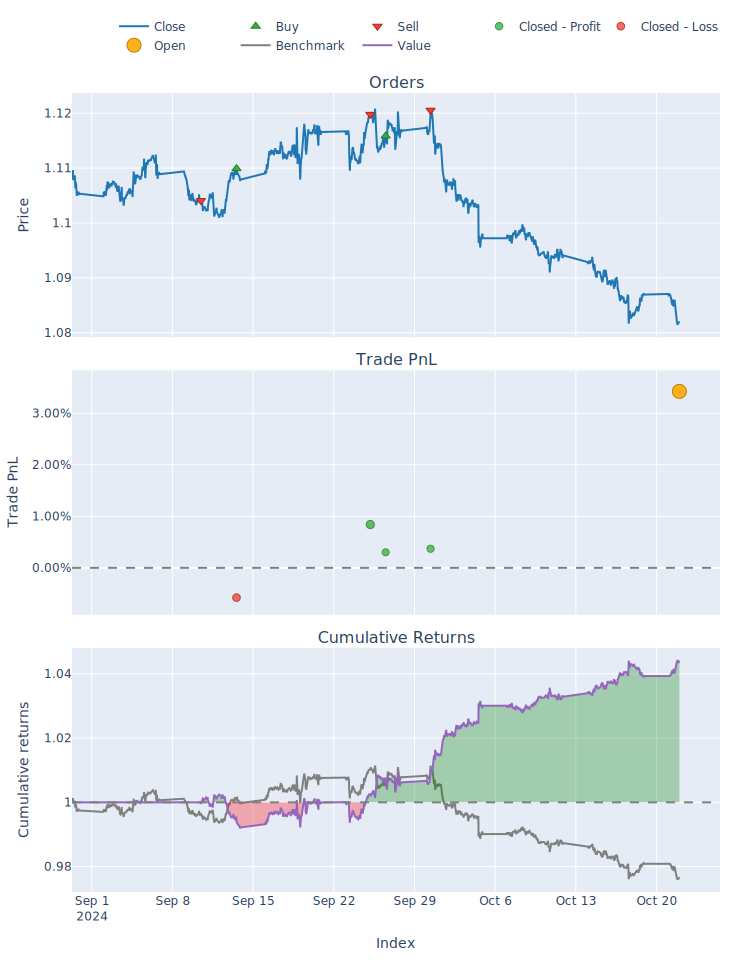

In [26]:
dmac_pf.plot().show_svg()

In [27]:
dmac_pf.stats()

,0
Start,2024-08-30 07:00:00
End,2024-10-21 23:30:00
Period,36 days 05:00:00
Start Value,10000.0
End Value,10438.756967
Total Return [%],4.38757
Benchmark Return [%],-2.36936
Max Gross Exposure [%],100.0
Total Fees Paid,22.566782
Max Drawdown [%],1.047776


##总结
本策略总体回报率为4.39%，显著超过基准回报的-2.37%，最大回撤为1.05%，胜率75%，夏普比率6.96，说明策略在承担风险的同时实现了相对较高的收益。

未来可以改进的方面：
1. 针对不同方向的平仓时机设置不同的策略
2. 引入更多因子进行信号确认，比如RSI或布林带提高稳健性
3. 增强仓位管理
4. 通过滚动向前测试（walk-forwad test）等方式对策略进行更加稳健的评估和优化
5. 使用机器学习来优化进出场信号

下面是一个滑动模块，通过滑动图片上方的控制条，可以实时看到不同快慢窗口的可视化信息和基本的回测结果

In [28]:
perf_metrics=['total_return','positions.win_rate','positions.expectancy','max_drawdown']
perf_metrics_names=['Total return','Win rate','Expectancy','Max drawdown']
windows_slider=widgets.IntRangeSlider(
    value=[fast_win,slow_win],
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)
dmac_fig=None
dmac_img=widgets.Image(
    format='png',
    width=vbt.settings['plotting']['layout']['width'],
    height=vbt.settings['plotting']['layout']['height']
    )
metrics_html=widgets.HTML()

In [29]:
def on_value_change(value):
  global dmac_fig
  #建立策略模型
  fast_win,slow_win=value['new']
  fast_ma=vbt.MA.run(data['Open'],fast_win)
  slow_ma=vbt.MA.run(data['Open'],slow_win)
  dmac_entries=fast_ma.ma_crossed_above(slow_ma)
  dmac_exits=fast_ma.ma_crossed_below(slow_ma)
  dmac_pf=vbt.Portfolio.from_signals(data['Close'],dmac_entries,dmac_exits)
  #可视化并更新数据
  if dmac_fig is None:
    dmac_fig=data['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
    fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'),fig=dmac_fig)
    slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'),fig=dmac_fig)
    dmac_entries.vbt.signals.plot_as_entry_markers(data['Open'],fig=dmac_fig)
    dmac_exits.vbt.signals.plot_as_exit_markers(data['Open'],fig=dmac_fig)
  else:
    with dmac_fig.batch_update():
      dmac_fig.data[1].y=fast_ma.ma
      dmac_fig.data[2].y=slow_ma.ma
      dmac_fig.data[3].x=data['Open'].index[dmac_entries]
      dmac_fig.data[3].y=data['Open'][dmac_entries]
      dmac_fig.data[4].x=data['Open'].index[dmac_exits]
      dmac_fig.data[4].y=data['Open'][dmac_exits]
  dmac_img.value=dmac_fig.to_image(format='png')

  sr=pd.Series([dmac_pf.deep_getattr(m) for m in perf_metrics],
               index=perf_metrics_names,name='Performance')
  metrics_html.value=sr.to_frame().style.set_properties(**{'text-align':'right'}).to_html()

windows_slider.observe(on_value_change,names='value')
on_value_change({'new':windows_slider.value})
dashboard=widgets.VBox([
    widgets.HBox([widgets.Label('Fast and slow window:'),windows_slider]),
    dmac_img,
    metrics_html
])
dashboard

In [38]:
dashboard.close()
gc.collect()

160976